<b>Arnie Larson<br>
EEP 592 - Radar, Autumn 2022<br>
HW5<br>
11/08/2022</b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.io import wavfile


<b>1)</b><br>

A FMCW radar is to be modeled.  (e.g. a blind spot warning system) 

- Center frequency: 24 GHz
- triangular sweep (LFM) from 23 GHz to 25 GHz in 5 us, and then back down at 10 us
- generate this LFM chirp signal, sampled at 75 GHz, for a period of 100 us

a) Model this signal

I'm considering an LFM chirp to be modeled as $a_0(t) cos(a_1*t + a_2*t^2 + \phi_0)$.  Given a desired frequency $f_0$ at $t=0$ and a desired frequency $f_1$ at $t_1$ I can find $\phi(t)$ via the definition $\omega(t) = \frac{d\phi(t)}{dt}$ and from this I find $\phi(t) = \omega_0*t + \frac{(\omega_1-\omega_0)}{2 t_1}*t^2 + \phi_0$.

b) Plot the spectrum and the spectrogram of this signal.

c) Consider the return from a target at 10m (e.g. a car in the blindspot moving at the same speed) having a return signal 1% of the transmitted signal amplitude

At 10m, the time deltay will be 2 * 3.3 e-8 or 0.066 us.  Plot this return signal including the modeled time delay.

d) Simulate the signal mixer at the receiver:  S1 * S2 and plot the spectrum of the receivers mixer output.

The spectrum clearly shows the expected beat frequencies for the mixed signal at the receiver.

f) Consider the return of another target at 30m, returning a signal with 0.5% of the transmitted signal.

This return will have a time delay of 3 x that at 10m, 6 * 3.3 e-8 or 0.198 us.  Plot this return signal including the modeled time delay.

#### Takeaway

The spectrum of the mixed signal with returns now clearly shows two returns, with amplitudes proportional to the return amplitude.  (2nd attempt.)  I now clearly see beat frequencies that are $\approx \frac{\beta}{T} t_0$. Since the beat frequencies are present througout signal, spectral response is much stronger, the chirp spectrum is still there, but has bandwidth $w\beta$ and begins at 25 GHz.


In [2]:
# contsruct chirp signal
c=3e8; f0=23e9; f1=25e9; 

In [3]:
tf=100e-6; fs=75e9;       # 100e-6 * 75e9 = 7500 e3 = 7.5M points
t = np.linspace(0,tf, np.int(fs*tf))

In [4]:
# Functions to help generate LFM pulses
# find general form: f = mt + b
# m = (f1-f0)/(t1-t0); b = f0-t0*m

def generate_lfm_chirp(t, a0, f0, f1, t0, t1, phi0=0.0):
    # return chirp signal 
    S = a0*np.cos(2*np.pi*f0*t + np.pi*((f1-f0)/dt)*t**2 + phi0)
    return S

def generate_lfm_chirp_phase(t, a0, f0, f1, t0, t1, phi0):
    # return chirp signal 
    m = (f1-f0)/(t1-t0)
    b = f0 - t0*m
    phase = np.pi*(2*b*t + m*t**2 + phi0)
    return phase

# modify in place, from idx0 to idx1-1
# check boundary of second index
def inplace_lfm_chirp(t, s, idx0, idx1, a0, f0, t0, m, phi0=0.0):
    # return chirp signal: b= f0 - t0*m; m=(f1-f0)/(t1-t0), phi(t) = 2*pi*(b*t + 1/2*m*t^2)
    if idx0 >= t.shape[0]: 
        raise ValueError("Start index too large")
    if s.shape[0] != t.shape[0]:
        raise ValueError("Mismatched data")
    b = f0 - t0*m
    idx1=idx1 if idx1 <= t.shape[0] else t.shape[0]
    s[idx0:idx1] = a0*np.cos(2*np.pi*b*t[idx0:idx1] + np.pi*m*t[idx0:idx1]**2 + phi0)
    #pt=np.arccos(s[idx1-1]/a0)
    #phase=pt-2*np.pi*f0*t[idx1-1] - (f1-f0)/dt*t[idx1-1]**2
    #return phase
    
# at boundary point t require phase to be continuous
# phi_1 = 2pi*(b1t + 1/2*m1t^2 + phi1); phi_2 = 2pi*(b2t + 1/2*m2t^2 + phi2)
# solve for and return phi2-phi1
def get_delta_phi(t, f1, t10, m1, f2, t20, m2, phi1):
    # I should be able to just get the m delta_f / delta_t
    b1=f1 - m1*t10
    b2=f2 - m2*t20
    dphi = 2*np.pi*(b1-b2)*t + np.pi*(m1-m2)*t**2 + phi1
    dphi = np.mod(dphi, 2*np.pi)
    #print("phi1: {};  phi2: {}".format(phi1,dphi))
    return dphi




In [5]:
## Function to generate the FMCW pulses
#
#  dt = chirp time
#  tf = total time
#  fs = sample rate
#  offset = 
#  
def generate_lfm_signal(dt,tf,a,fs,f0,f1,offset=0,up=True):
    t=np.linspace(0,tf,np.int(tf*fs))  
    # create little helper function to help with extrapolating time points
    _dt=t[1]-t[0]
    _t = lambda x : x*_dt
    s=np.zeros(t.shape[0])
    di = np.int(dt*fs)
    idx0=offset
    idx1=idx0+di
    phi=0.01
    init=True
    j=0
    m1 = (f1-f0)/(t[idx1-1]-t[idx0])

    while idx0 < t.shape[0]:
        j+=1
        #print("idx0 is: {}, idx1 is: {}".format(idx0, idx1))
        if idx1 > t.shape[0]:
            #print("idx1 is: {}, s.shape[0] is: {}, setting idx1 to {}".format(idx1, s.shape[0], s.shape[0]))
            idx1 = t.shape[0]
        if up:
            if not init:  # m for second one = delta f over delta t
                phi = get_delta_phi(_t(idx1-1), f0, _t(idx0), m1, f1, _t(idx1-1), -m1, phi)
            inplace_lfm_chirp(t, s, idx0, idx1, a, f0, _t(idx0), m1, phi)
            up=False
        else:
            if not init:
                phi = get_delta_phi(_t(idx1-1), f0, _t(idx0), -m1, f1, _t(idx1-1), m1, phi)
            inplace_lfm_chirp(t, s, idx0, idx1, a, f1, _t(idx0), -m1, phi)
            up=True
        init=False
        idx0=idx1
        idx1+=di
        if j > 100:
            break
            
    return s

In [76]:
# Generate signal, T_chirp = 5us, Duration=100us, amplitude=1.0, Fsample=75GHz, Fmin=23GHz, Fmax=25GHz
S1 = generate_lfm_signal(5e-6, 100e-6, 1.0, 75e9, 23e9, 25e9, offset=0, up=True)

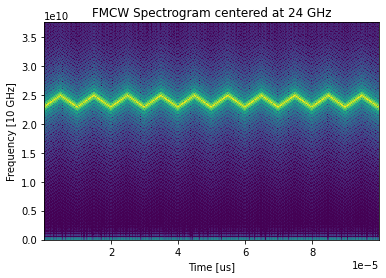

In [77]:
fx, tx, Sx = signal.spectrogram(S1, fs, nperseg=256*4) #, nfft=256*2)
plt.pcolormesh(tx, fx, Sx, shading="auto", norm=colors.LogNorm(vmin=Sx.min()+1e-22, vmax=Sx.max()))
plt.xlabel("Time [us]"), plt.ylabel("Frequency [10 GHz]")
plt.title("FMCW Spectrogram centered at 24 GHz")
plt.show()


In [78]:
# Geometry of the signal sample space
N=S1.shape[0]
print(N/2)

3750000.0


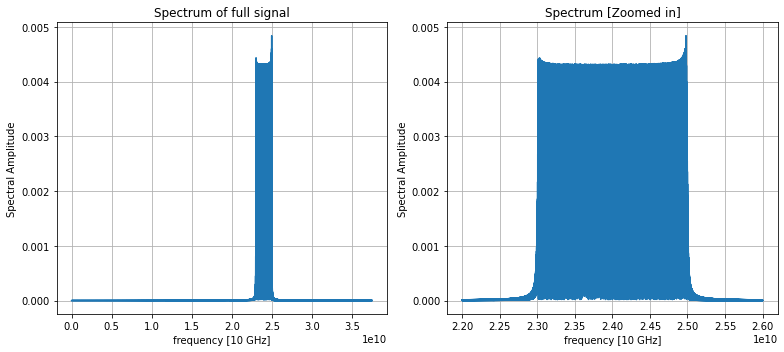

In [79]:
# Plotting the Fourier Spectrum of the signal - expected 23 GHz - 25 GHz
FS1 = fft(S1)
T=t[1]-t[0]
fS1 = fftfreq(N, T)[:N//2]

# zoom in on signal
idx_start=2200000; idx_end=2600000
FS1_zoom = 2.0/N * np.abs(FS1[idx_start:idx_end])
fs1_zoom = fS1[idx_start:idx_end]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11, 5))
ax1.plot(fS1, 2.0/N * np.abs(FS1[0:N//2]))
ax1.set_ylabel("Spectral Amplitude"); ax1.set_xlabel("frequency [10 GHz]")
ax1.set_title("Spectrum of full signal"); ax1.grid()
ax2.plot(fs1_zoom, FS1_zoom)
ax2.set_ylabel("Spectral Amplitude"); ax2.set_xlabel("frequency [10 GHz]")
ax2.set_title("Spectrum [Zoomed in]"); ax2.grid()
fig.tight_layout()
plt.show()

In [80]:
## Generate return with a signal at 10m, with 1% of the amplitude
## Assumption is that the signal is delayed by t = 2*d/c = 0.066us
return_time = 2*10/c; print("time delay of return (10m): {}".format(return_time))
## index of this is 
n_indx = return_time / (t[1] - t[0]); print("Index of target return (10m) (in time): {}".format(n_indx))

time delay of return (10m): 6.666666666666667e-08
Index of target return (10m) (in time): 4999.999333333333


In [81]:
# Generate return signal, T_chirp = 5us, Duration=100us, amplitude=0.01, Fsample=75GHz, Fmin=23GHz, Fmax=25GHz
# return signal at 10m begins after 0.066 us, or about 5000 time points
S2 = generate_lfm_signal(5e-6, 100e-6, 0.01, 75e9, 23e9, 25e9, offset=5000, up=True)

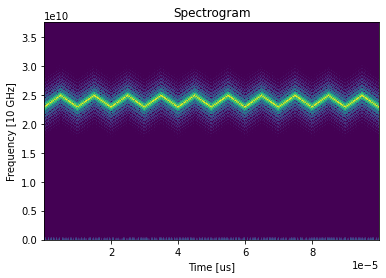

In [82]:
fx, tx, Sx = signal.spectrogram(S2, fs, nperseg=256*4) #, nfft=256*2)
plt.pcolormesh(tx, fx, Sx, shading="auto", norm=colors.LogNorm(vmin=Sx.min()+1e-22, vmax=Sx.max()))
plt.xlabel("Time [us]"), plt.ylabel("Frequency [10 GHz]")
plt.title("Spectrogram")
plt.show()

In [83]:
# Simulate mixer, elment wise product
M1 = S1*S2

In [84]:
print(FM1.shape)
print(fM1.shape)

(7500000,)
(3750000,)


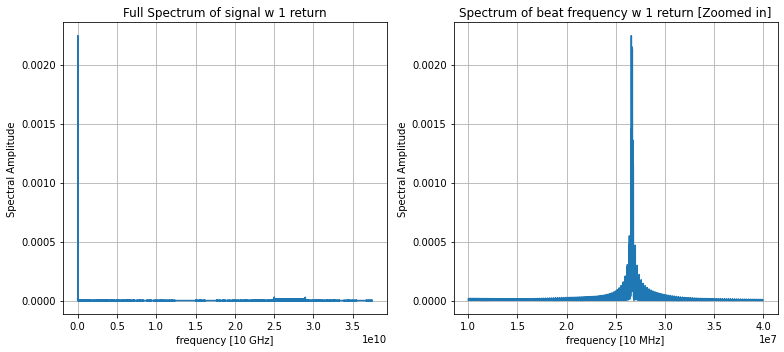

In [109]:
# Plotting tips: [https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side]
# Plotting the Fourier Spectrum of the signal - with mix of target
FM1 = fft(M1)
# T is time delta, 1/FS
fM1 = fftfreq(N, T)[:N//2]
idx_start_wide=0; idx_end_wide=7500000
idx_start=1000; idx_end=4000
FM1_wide = 2.0/N * np.abs(FM1[idx_start_wide:N//2])
FM1_zoom = 2.0/N * np.abs(FM1[idx_start:idx_end])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11, 5))
ax1.plot(fM1[idx_start_wide:], FM1_wide)
ax1.set_title("Full Spectrum of signal w 1 return")
ax1.set_ylabel("Spectral Amplitude"); ax1.set_xlabel("frequency [10 GHz]")
ax1.grid()
ax2.plot(fM1[idx_start:idx_end], FM1_zoom)
ax2.set_title("Spectrum of beat frequency w 1 return [Zoomed in]")
ax2.set_ylabel("Spectral Amplitude"); ax2.set_xlabel("frequency [10 MHz]")
ax2.grid()
fig.tight_layout()
plt.show()

In [97]:
# Generate return signal, T_chirp = 5us, Duration=100us, amplitude=0.005, Fsample=75GHz, Fmin=23GHz, Fmax=25GHz
# return signal at 30m begins after 3x0.066 us, or about 15000 time points
S3 = generate_lfm_signal(5e-6, 100e-6, 0.005, 75e9, 23e9, 25e9, offset=15000, up=True)

In [98]:
# Simulate mixer, elment wise product, now return is sum of two signals at receiver
M2 = S1*(S2+S3)

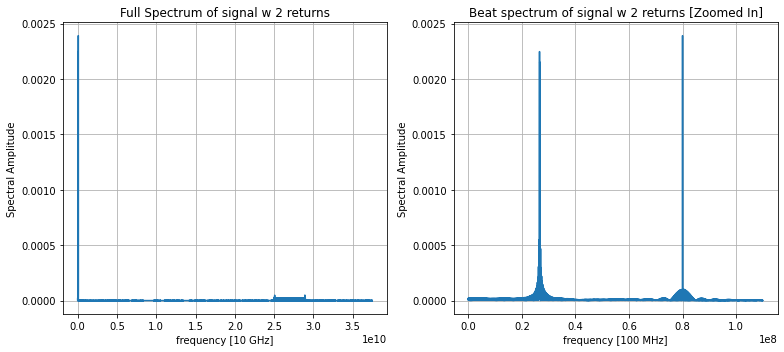

Confirms the two beat frequencies: 26.4 MHz; 79.2 MHz


In [107]:
# Plotting tips: [https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side]
# Plotting the Fourier Spectrum of the signal + return of two targets
FM2 = fft(M2)
# T is time delta, 1/FS
#fM1 = fftfreq(N, T)[:N//2]
#idx_start=2670000; idx_end=2720000
idx_start_wide=0; idx_end_wide=3750000
idx_start=0; idx_end=11000
fm2_wide = fM1[idx_start_wide:idx_end_wide]
FM2_wide = 2.0/N * np.abs(FM2[idx_start_wide:idx_end_wide])


FM2_zoom = 2.0/N * np.abs(FM2[idx_start:idx_end])
fm2_zoom = fM1[idx_start:idx_end]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11, 5))
ax1.plot(fm2_wide, FM2_wide)
ax1.set_title("Full Spectrum of signal w 2 returns")
ax1.set_ylabel("Spectral Amplitude"); ax1.set_xlabel("frequency [10 GHz]")
ax1.grid()
ax2.plot(fm2_zoom, FM2_zoom)
ax2.set_title("Beat spectrum of signal w 2 returns [Zoomed In]")
ax2.set_ylabel("Spectral Amplitude"); ax2.set_xlabel("frequency [100 MHz]")
ax2.grid()
fig.tight_layout()
plt.show()
b1 = 0.066*2e9/5. # t_0 * beta/T
b2 = 3*0.066*2e9/5. # t_0 * beta/T;  3 times t_0 of first return
print("Confirms the two beat frequencies: {} MHz; {} MHz".format(b1*1e-6,b2*1e-6))